In [1]:
import os
import json
import numpy as np
from tqdm import tqdm
from skimage import io, util, transform, draw, color, img_as_ubyte
from preprocess import utils
from extract_lcd import extract_display

In [2]:
DEFAULT_IMAGE_SHAPE = (450, 800, 3)

In [3]:
def segmentation2polygon(segmentation):
    if segmentation.ndim == 2:
        segmentation = np.array(segmentation[0])
    elif segmentation.ndim == 1:
        segmentation = np.array(segmentation)
    else:
        raise ValueError
    yy = segmentation[0::2]
    xx = segmentation[1::2]
    polygon = np.c_[xx,yy]
    return polygon

    
def iou_score(mask_true, mask_pred):
    intersection = np.logical_and(mask_true, mask_pred)
    union = np.logical_or(mask_true, mask_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [4]:
def calculate_iou(image_dir, path_annotation):
    
    img_names, iou_scores = [], []

    with open(path_annotation) as file:
        data = json.load(file)
        
    for img_info, img_annotation in tqdm(zip(data['images'], data['annotations']), desc="Progress"):
        # determine image path
        img_name = img_info['file_name']
        img_path = os.path.join(image_dir, img_name)    
        
        # read image
        img = util.img_as_float64(io.imread(img_path))
        _, mask_pred, _ = extract_display(img, shape=DEFAULT_IMAGE_SHAPE, plot=False)
        
        # retrieve polygon
        segmentation = np.array(img_annotation['segmentation'])
        polygon = segmentation2polygon(segmentation)
        
        # compute mask
        mask_true = draw.polygon2mask(img.shape[0:2], polygon)
        mask_true = transform.resize(mask_true, output_shape=DEFAULT_IMAGE_SHAPE[:2])
        mask_true = utils.pad_binary_image(mask_true, dh=20, dw=20)
        mask_true = mask_true.astype(np.uint8)
        
        img_iou = iou_score(mask_true, mask_pred)
        # print(f'IoU = {img_iou}')
        
        img_names.append(img_name)
        iou_scores.append(img_iou)
    return img_names, iou_scores

In [5]:
image_dir_1 = '/home/aboumessouer/Downloads/YUVA_EB_DATASET/RAW_IMAGES/1_Day_Light/'
path_annotation_1 = 'annotations/annotations_01_daylight.json'
img_names_1, iou_scores_1 = calculate_iou(image_dir_1, path_annotation_1)

Progress: 50it [12:16, 14.73s/it]


In [7]:
image_dir_2 = '/home/aboumessouer/Downloads/YUVA_EB_DATASET/RAW_IMAGES/2_Night/'
path_annotation_2 = 'annotations/annotations_02_night.json'
img_names_2, iou_scores_2 = calculate_iou(image_dir_2, path_annotation_2)

Progress: 48it [10:53, 13.62s/it]


In [8]:
image_dir_3 = '/home/aboumessouer/Downloads/YUVA_EB_DATASET/RAW_IMAGES/3_Tilted/'
path_annotation_3 = 'annotations/annotations_03_tilted.json'
img_names_3, iou_scores_3 = calculate_iou(image_dir_3, path_annotation_3)

Progress: 50it [13:28, 16.17s/it]


In [9]:
image_dir_4 = '/home/aboumessouer/Downloads/YUVA_EB_DATASET/RAW_IMAGES/4_Blurred/'
path_annotation_4 = 'annotations/annotations_04_blurred.json'
img_names_4, iou_scores_4 = calculate_iou(image_dir_4, path_annotation_4)

Progress: 20it [05:21, 16.05s/it]


In [34]:
categories = ['1_Day_Light']*len(img_names_1) + ['2_Night']*len(img_names_2) + ['3_Tilted']*len(img_names_3) + ['4_Blurred']*len(img_names_4)
img_names = img_names_1 + img_names_2 + img_names_3 + img_names_4
iou_scores = iou_scores_1 + iou_scores_2 + iou_scores_3 + iou_scores_4
dict_results = {'img_name': img_names, 'category': categories, 'iou_score': iou_scores}

In [35]:
import pandas as pd
df_results = pd.DataFrame(data=dict_results)

In [36]:
df_results

,img_name,category,iou_score
0,001.JPG,1_Day_Light,0.895251
1,002.JPG,1_Day_Light,0.960099
2,003.JPG,1_Day_Light,0.892853
3,004.JPG,1_Day_Light,0.841683
4,005.JPG,1_Day_Light,0.911559
...,...,...,...
163,165.JPG,4_Blurred,0.937832
164,166.JPG,4_Blurred,0.937056
165,167.JPG,4_Blurred,0.021171
166,168.JPG,4_Blurred,0.809365


In [37]:
df_results.to_csv('results.csv', header=True)

In [52]:
latex_results = df_results.to_latex(index=False, float_format="%.2f", longtable=True)
# print(latex_results)

In [46]:
# from statistics import mean
# df_results.groupby(by='category').agg(
#     {
#          'iou_score':[mean, min, max],
#     }
# )

df_summary = df_results.groupby(by='category').describe()
df_summary

iou_score                                                    \
                count      mean       std       min       25%       50%   
category                                                                  
1_Day_Light      50.0  0.899171  0.070703  0.490584  0.880680  0.908399   
2_Night          48.0  0.914371  0.047579  0.733776  0.904953  0.924169   
3_Tilted         50.0  0.894636  0.098656  0.448946  0.894125  0.918802   
4_Blurred        20.0  0.847843  0.203574  0.021171  0.857917  0.911042   

                                 
                  75%       max  
category                         
1_Day_Light  0.927447  0.979789  
2_Night      0.941920  0.989232  
3_Tilted     0.940237  0.966984  
4_Blurred    0.935889  0.951105

In [58]:
# print(df_summary.to_latex(index=False, float_format="%.2f", longtable=True, multicolumn=True))

<AxesSubplot:title={'center':'iou_score'}, xlabel='category'>

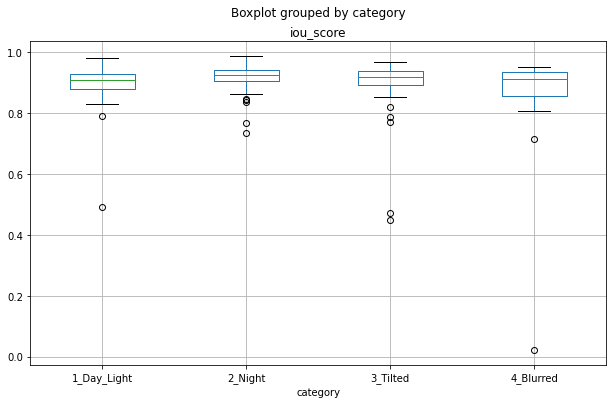

In [56]:
df_results.boxplot(by='category', column='iou_score', figsize=(10,6))